# Sentiment Analysis

In [7]:
import csv
import pandas as pd 
import random
import numpy as np
import tensorflow as tf
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress
from bs4 import BeautifulSoup
import re
pd.set_option('display.max_colwidth', None) 

In [8]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

In [9]:
#importing the training data
imdb_data=pd.read_csv('../data/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(3)

(50000, 2)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive


In [10]:
#Removing the noisy text
def denoise_text(text):
    text = BeautifulSoup(text, "html.parser").get_text() # html tags
    text = re.sub(r'\[[^]]*\]', '', text) # square brackets
    text = re.sub(r'[^a-zA-z0-9\s]', '', text) # special characters
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)
imdb_data.head(3)

C:\Users\Yoseph\AppData\Local\Temp\ipykernel_4948\768091965.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text() # html tags


,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty pictures painted for mainstream audiences forget charm forget romanceOZ doesnt mess around The first episode I ever saw struck me as so nasty it was surreal I couldnt say I was ready for it but as I watched more I developed a taste for Oz and got accustomed to the high levels of graphic violence Not just violence but injustice crooked guards wholl be sold out for a nickel inmates wholl kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience Watching Oz you may become comfortable with what is uncomfortable viewingthats if you can get in touch with your darker side,positive
1,A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done,positive
2,I thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a lighthearted comedy The plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer While some may be disappointed when they realize this is not Match Point 2 Risk Addiction I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to loveThis was the most Id laughed at one of Woodys comedies in years dare I say a decade While Ive never been impressed with Scarlet Johanson in this she managed to tone down her sexy image and jumped right into a average but spirited young womanThis may not be the crown jewel of his career but it was wittier than Devil Wears Prada and more interesting than Superman a great comedy to go see with friends,positive


In [11]:
# Convert sentiment labels to 1 (positive) and 0 (negative)
imdb_data['sentiment'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})

In [12]:
sentences = imdb_data['review'].tolist()
labels = imdb_data['sentiment'].tolist()
labels[-5:]
# sentences[2]

[1, 0, 0, 0, 0]

## train - validation 

In [13]:
def train_val_split(sentences, labels, training_split):
         
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [14]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)


In [15]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """    
    # Instantiate the Tokenizer class, passing in the correct value for oov_token
    tokenizer = Tokenizer(oov_token=oov_token)

    # Generate the word index dictionary
    tokenizer.fit_on_texts(train_sentences)
    
    # Fit the tokenizer to the training sentence    
    return tokenizer

In [16]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary size {VOCAB_SIZE} words\n")

Vocabulary size 208515 words



In [18]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
           
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)    
    return pad_trunc_sequences

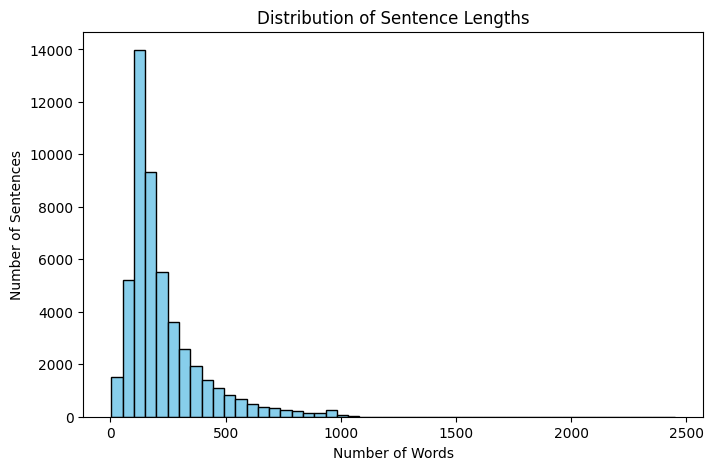

Mean length: 226.18
Median length: 170.0
95th percentile: 577.0


In [19]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in sentences]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Sentences')
plt.show()

# Optional: See some statistics
print(f"Mean length: {np.mean(sentence_lengths):.2f}")
print(f"Median length: {np.median(sentence_lengths)}")
print(f"95th percentile: {np.percentile(sentence_lengths, 95)}")

In [21]:
# Test function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, 250)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, 250)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (45000, 250)

Padded and truncated validation sequences have shape: (5000, 250)


In [20]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

## using embeddings

In [22]:
# Define path to file containing the embeddings
GLOVE_FILE = '../data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [23]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [24]:
#  create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
         
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 
    return model

In [25]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    20,851,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,851,600 (79.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,851,600 (79.54 MB)

In [26]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6320 - loss: 0.6281 - val_accuracy: 0.8268 - val_loss: 0.4059
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8057 - loss: 0.4249 - val_accuracy: 0.8328 - val_loss: 0.3823
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8283 - loss: 0.3831 - val_accuracy: 0.8324 - val_loss: 0.3715
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8403 - loss: 0.3605 - val_accuracy: 0.8388 - val_loss: 0.3620
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8496 - loss: 0.3428 - val_accuracy: 0.8390 - val_loss: 0.3691
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8620 - loss: 0.3260 - val_accuracy: 0.8466 - val_loss: 0.3542
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8659 - loss: 0.3099 - val_accuracy: 0.8378 - val_loss: 0.3639
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8710 - lo

### loss

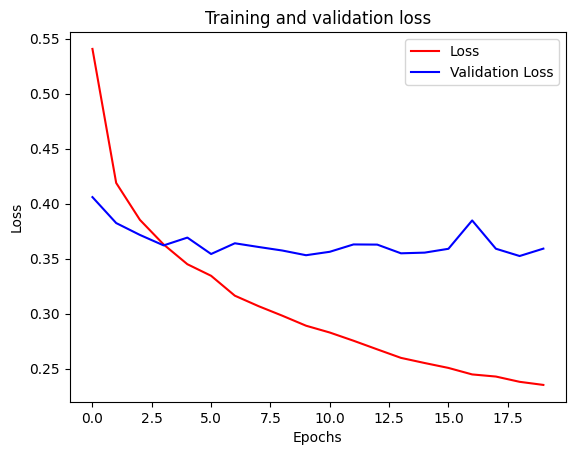

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [*range(20)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

### accuracy

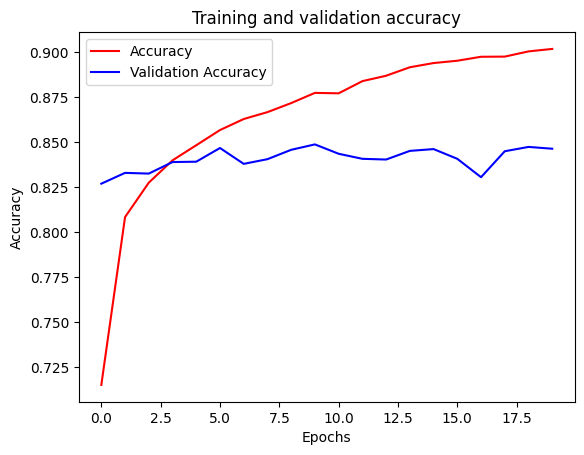

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

### test 

In [ ]:
# Test example 1
sent1 = "I really loved the movie! It was fantastic."
test_seq = tokenizer.texts_to_sequences([sent1])
test_seq_padded = pad_sequences(test_seq, maxlen=250, padding='post', truncating='post')  
prediction1 = model.predict(test_seq_padded)
print(prediction1)
label1 = "Positive" if prediction1[0][0] >= 0.5 else "Negative"
label1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.9528096]]


'Positive'

In [ ]:
# Test example 2
sent2 = "I had high hopes for this movie based on the trailer, but it turned out to be one of the most disappointing experiences I've had in a long time. The plot was painfully predictable and dragged on with no real sense of direction or purpose. Characters lacked depth, and their motivations were either unclear or completely unrealistic. The dialogue felt forced and unnatural, as if the writers were trying too hard to sound clever without any real substance behind the words. The pacing was inconsistent — some scenes felt unbearably slow, while others rushed through important developments without giving the audience a chance to connect. On top of that, the visuals were mediocre at best, with special effects that looked outdated and uninspired. "
test_seq = tokenizer.texts_to_sequences([sent2])
test_seq_padded = pad_sequences(test_seq, maxlen=250, padding='post', truncating='post')  
prediction2 = model.predict(test_seq_padded)
print(prediction2)
label2 = "Positive" if prediction2[0][0] >= 0.5 else "Negative"
label2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.00206131]]


'Negative'

In [35]:
model.save("sentiment_model.keras")